# AutoML project 1



Project team: Oliver Püvi, Li Merila, Karolin Rips, Susanna Metsla, Annika Talvet

In [ ]:
#!pip install hyperopt

In [33]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MaxAbsScaler
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import BayesianRidge
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.model_selection import cross_val_score
from hyperopt import hp, fmin, tpe, Trials, STATUS_OK, space_eval
from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline
import matplotlib.pyplot as plt
from scipy.stats import ttest_rel
import warnings
warnings.filterwarnings('ignore')

## Reading in the data, preprocessing

In [2]:
df = pd.read_csv('insurance.csv')
df

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520
...,...,...,...,...,...,...,...
1333,50,male,30.970,3,no,northwest,10600.54830
1334,18,female,31.920,0,no,northeast,2205.98080
1335,18,female,36.850,0,no,southeast,1629.83350
1336,21,female,25.800,0,no,southwest,2007.94500


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


There are no missing values in our dataset, but we have to enocode nominal variables.

In [5]:
# Initialize label encoders
label_encoder_dept = LabelEncoder()
label_encoder_salary = LabelEncoder()

# Apply Label Encoding to 'sex' and 'smoker' and 'region' columns
df['sex_encoded'] = label_encoder_dept.fit_transform(df['sex'])
df['smoker_encoded'] = label_encoder_salary.fit_transform(df['smoker'])
df['region_encoded'] = label_encoder_salary.fit_transform(df['region'])
df['charges'] = (df['charges']-df['charges'].min()) /( df['charges'].max() -df['charges'].min())

# Drop original  'sex' and 'smoker' and 'region' columns
encoded_df = df.drop(['sex', 'smoker', 'region'], axis = 1)

# Ensure the DataFrame is of type float64
encoded_df = encoded_df.astype('float64')

# Check data types
print(encoded_df.dtypes)

age               float64
bmi               float64
children          float64
charges           float64
sex_encoded       float64
smoker_encoded    float64
region_encoded    float64
dtype: object


In [6]:
encoded_df.describe()

,age,bmi,children,charges,sex_encoded,smoker_encoded,region_encoded
count,1338.000000,1338.000000,1338.000000,1338.000000,1338.000000,1338.000000,1338.000000
mean,39.207025,30.663397,1.094918,0.193916,0.505232,0.204783,1.515695
std,14.049960,6.098187,1.205493,0.193301,0.500160,0.403694,1.104885
min,18.000000,15.960000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,27.000000,26.296250,0.000000,0.057757,0.000000,0.000000,1.000000
50%,39.000000,30.400000,1.000000,0.131849,1.000000,0.000000,2.000000
75%,51.000000,34.693750,2.000000,0.247700,1.000000,0.000000,2.000000
max,64.000000,53.130000,5.000000,1.000000,1.000000,1.000000,3.000000


## Baseline

To construct the baseline, we are trying a set of possible machine learning algorithms (13 algorithms) using their default hyperparamters and we choose the one with the highest performance for comparison (baseline model).

In [39]:
X = encoded_df.drop('charges', axis = 1)
y = encoded_df['charges']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

seed=42

models = {
    "Linear Regression": LinearRegression(),
    "Ridge Regression": Ridge(random_state=seed),
    "Lasso": Lasso(random_state=seed),
    "Elastic Net": ElasticNet(random_state=seed),
    "Bayesian Ridge Regression": BayesianRidge(),
    "Decision Tree": DecisionTreeRegressor(random_state=seed),
    "Random Forest": RandomForestRegressor(random_state=seed),
    "Gradient Boosting Regressor": GradientBoostingRegressor(random_state=seed),
    "AdaBoost Regressor": AdaBoostRegressor(random_state=seed),
    "ExtraTrees Regressor": ExtraTreesRegressor(random_state=seed),
    "KNeighbors Regressor": KNeighborsRegressor(),
    "Support Vector Regressor": SVR(),
    "Gaussian Process Regressor": GaussianProcessRegressor(random_state=seed)
}

results = {}

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    results[name] = mse

sorted_results = sorted(results.items(), key = lambda x: x[1], reverse = True)

for name, mse in sorted_results:
    print(f"{name}: MSE = {mse}")

baseline_model_name = min(results, key=results.get)
baseline_mse = results[baseline_model_name]

print(f"\nBaseline Model: {baseline_model_name} with MSE = {baseline_mse}")

Gaussian Process Regressor: MSE = 0.04364101799888289
Lasso: MSE = 0.03959177723052456
Elastic Net: MSE = 0.037258555863864055
KNeighbors Regressor: MSE = 0.03376690738272361
Support Vector Regressor: MSE = 0.023284933463689064
Decision Tree: MSE = 0.012061586091509232
Ridge Regression: MSE = 0.008580166509918627
Bayesian Ridge Regression: MSE = 0.008573831199997817
Linear Regression: MSE = 0.008569826799446194
AdaBoost Regressor: MSE = 0.007068292466468052
ExtraTrees Regressor: MSE = 0.006027661460036185
Random Forest: MSE = 0.005379167375130177
Gradient Boosting Regressor: MSE = 0.004826843572287087

Baseline Model: Gradient Boosting Regressor with MSE = 0.004826843572287087


## Studying the potential pipeline structure

Based on the problem at hand, we study the potential pipeline structure,
algorithms or feature transformers at each step, hyper-parameters ranges. We are using hyperOpt with the potential search space to beat the baseline.

In [43]:
# Feature and target separation
X = encoded_df.drop('charges', axis=1)  # Features
y = encoded_df['charges']               # Target

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

# Defining a joint search space for hyperparameter optimization
space = {
    'regressor': hp.choice('regressor', [
        {
            'model': GradientBoostingRegressor,
            'n_estimators': hp.choice('gb_n_estimators', [50, 100, 200, 300, 400, 500]),
            'learning_rate': hp.uniform('gb_learning_rate', 0.01, 0.3),
            'subsample': hp.uniform('gb_subsample', 0.5, 1.0),
            'max_depth': hp.choice('gb_max_depth', [3, 5, 7, 9, None]),
            'min_samples_split': hp.choice('gb_min_samples_split', [2, 4, 6, 8, 10]),
            'min_samples_leaf': hp.choice('gb_min_samples_leaf', [1, 2, 4, 6, 8]),
            'max_features': hp.choice('gb_max_features', ['sqrt', 'log2', None])
        },
        {
            'model': RandomForestRegressor,
            'n_estimators': hp.choice('rf_n_estimators', [50, 100, 200, 300, 400, 500]),
            'max_depth': hp.choice('rf_max_depth', [5, 10, 15, 20, None]),
            'min_samples_split': hp.choice('rf_min_samples_split', [2, 4, 6, 8, 10]),
            'min_samples_leaf': hp.choice('rf_min_samples_leaf', [1, 2, 4, 6, 8]),
            'max_features': hp.choice('rf_max_features', ['sqrt', 'log2', None]),
            'bootstrap': hp.choice('rf_bootstrap', [True, False])
        },
        {
            'model': LinearRegression,
            'fit_intercept': hp.choice('lr_fit_intercept', [True, False])
        },
        {
            'model': Lasso,
            'alpha': hp.choice('alpha_lasso', [0.5, 1, 1.5, 2, 3, 4]),
            'selection': hp.choice('selection_lasso', ['cyclic', 'random']),
            'fit_intercept': hp.choice('fit_intercept_lasso', [True, False])
        },
        {
            'model': Ridge,
            'alpha': hp.choice('alpha_ridge', [0.5, 1, 1.5, 2, 3, 4]),
            'fit_intercept': hp.choice('fit_intercept_ridge', [True, False])
        },
        {
            'model': ElasticNet,
            'alpha': hp.choice('alpha_elastic', [0.5, 1, 1.5, 2, 3, 4]),
            'l1_ratio': hp.choice('l1_ratio_elastic', [0, 0.2, 0.4, 0.6, 0.8, 1]),
            'selection': hp.choice('selection_elastic', ['cyclic', 'random']),
            'fit_intercept': hp.choice('fit_intercept_elastic', [True, False])
        },
        {
            'model': BayesianRidge,
            'alpha_1': hp.choice('alpha_1', [0.000001, 0.000015, 0.000025, 0.00005, 0.0001]),
            'alpha_2': hp.choice('alpha_2', [0.000001, 0.000015, 0.000025, 0.00005, 0.0001]),
            'lambda_1': hp.choice('lambda_1', [0.000001, 0.000015, 0.000025, 0.00005, 0.0001]),
            'lambda_2': hp.choice('lambda_2', [0.000001, 0.000015, 0.000025, 0.00005, 0.0001]),
            'fit_intercept': hp.choice('fit_intercept_bayes', [True, False])
        },
        {
            'model': AdaBoostRegressor,
            'n_estimators': hp.choice('ab_n_estimators', [50, 100, 200, 300, 400, 500]),
            'learning_rate': hp.uniform('ab_learning_rate', 0.01, 0.3),
            'loss': hp.choice('ab_loss', ['linear', 'square', 'exponential'])
        },
        {
            'model': ExtraTreesRegressor,
            'n_estimators': hp.choice('etr_n_estimators', [50, 100, 200, 300, 400, 500]),
            'max_depth': hp.choice('etr_max_depth', [3, 5, 7, 9, None]),
            'min_samples_split': hp.choice('etr_min_samples_split', [2, 4, 6, 8, 10]),
            'min_samples_leaf': hp.choice('etr_min_samples_leaf', [1, 2, 4, 6, 8]),
            'max_features': hp.choice('etr_max_features', ['sqrt', 'log2', None])
        },
        {
            'model': DecisionTreeRegressor,
            'max_depth': hp.choice('dt_max_depth', [3, 5, 7, 9, None]),
            'min_samples_split': hp.choice('dt_min_samples_split', [2, 4, 6, 8, 10]),
            'min_samples_leaf': hp.choice('dt_min_samples_leaf', [1, 2, 4, 6, 8]),
            'max_features': hp.choice('dt_max_features', ['sqrt', 'log2', None]),
            'ccp_alpha': hp.uniform('dt_ccp_alpha', 0, 1),
        },
        {
            'model': KNeighborsRegressor,
            'n_neighbors': hp.choice('n_neighbors', [5, 10, 15, 20, 25, 30]),
            'weights': hp.choice('knn_weights', ['uniform', 'distance'])
        },
        {
            'model': GaussianProcessRegressor,
            'alpha': hp.choice('gpr_alpha', [1e-10, 1.5e-10, 3e-10, 0.5e-10, 1e-9]),
        },
        {
            'model': SVR,
            'epsilon': hp.choice('svr_epsilon', [0.1, 0.3, 0.5, 0.8]),
            'C': hp.choice('svr_c', [1, 2, 4, 6])
        }
    ]),

    'preprocessor': hp.choice('preprocessor', [
        {'standardscaler': StandardScaler},
        {'minmaxscaler': MinMaxScaler},
        {'maxabsscaler': MaxAbsScaler}
    ])
}

# Defining a function to optimize
def objective(params):
    # Extracting the regressor and preprocessor from the parameters
    regressor_params = params['regressor']
    preprocessor_params = params['preprocessor']

    preprocessor = list(preprocessor_params.values())[0]()
    regressor_model = regressor_params['model']
    regressor_args = {k: v for k, v in regressor_params.items() if k != 'model'}
    regressor = regressor_model(**regressor_args)

    # Creating a pipeline with the chosen regressor and preprocessor
    pipeline = make_pipeline(preprocessor, regressor)
    score = -cross_val_score(pipeline, X_train, y_train, cv=5, scoring='neg_mean_squared_error').mean()

    return {'loss': score, 'status': STATUS_OK}

# Optimizing hyperparameters
trials = Trials()
best_params = fmin(
    fn = objective,
    space = space,
    algo = tpe.suggest,
    max_evals = 250,
    trials = trials
)

# Extracting the best parameters
parameter_values = space_eval(space, best_params)
best_preprocessor = list(parameter_values['preprocessor'].values())[0]
best_regressor = parameter_values['regressor']['model']
remove_model = parameter_values['regressor'].pop('model')
best_param_values = parameter_values['regressor']

# Train the best model on the entire training data
best_pipeline = make_pipeline(best_preprocessor(), best_regressor(**best_param_values))
best_pipeline.fit(X_train, y_train)

# Evaluate the model on the test data
y_pred_test = best_pipeline.predict(X_test)
test_mse = mean_squared_error(y_test, y_pred_test)

# Results
print(f"Best preprocessor: {best_preprocessor.__name__}")
print(f"Best model: {best_regressor.__name__}")
print(f"Best hyperparameters: {best_param_values}")
print(f"Test MSE: {test_mse}")

100%|██████████| 250/250 [04:36<00:00,  1.11s/trial, best loss: 0.005472000292364413]
Best preprocessor: MaxAbsScaler
Best model: RandomForestRegressor
Best hyperparameters: {'bootstrap': True, 'max_depth': 5, 'max_features': None, 'min_samples_leaf': 6, 'min_samples_split': 6, 'n_estimators': 100}
Test MSE: 0.004809140794943822


## Monitoring the performance of the constructed pipeline

Monitoring the the performance of the constructed pipeline from the previous step across different time budgets (number of iterations) and reporting the least time budget that you are able to outperform the baseline.

In [44]:
trial_numbers = []
mses =  []
for trial in trials:
  trial_nr = trial['tid'] + 1
  trial_numbers.append(trial_nr)
  pipeline_mse_trial = trial['result']['loss']
  mses.append(pipeline_mse_trial)

In [45]:
least_time_budget = 1000000
for trial in trials:
  trial_nr = trial['tid']+1
  pipeline_mse_trial = trial['result']['loss']
  if (pipeline_mse_trial < baseline_mse):
    least_time_budget = trial_nr
    break

print(f"The least time budget that we are able to outperform the baseline: {least_time_budget}")

The least time budget that we are able to outperform the baseline: 1000000


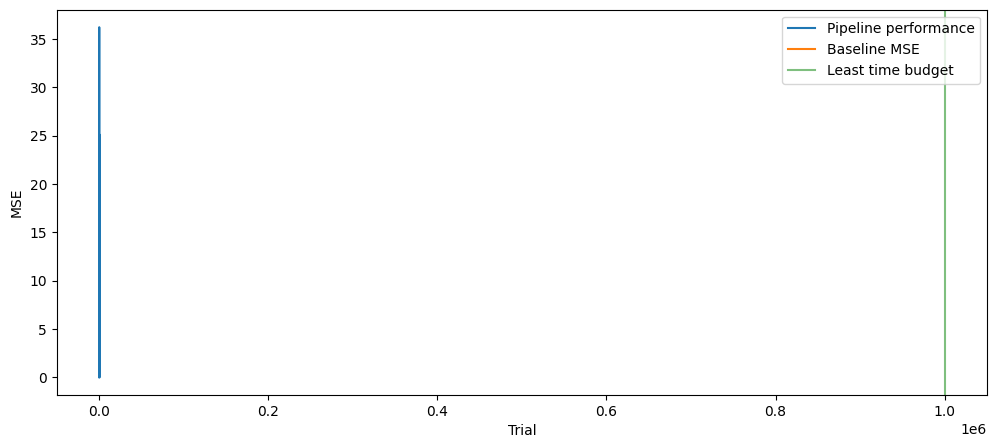

In [46]:
fig = plt.figure(figsize=(12, 5))
plt.plot(trial_numbers, mses, label = 'Pipeline performance')
plt.plot(trial_numbers, [baseline_mse]*len(trial_numbers), label = 'Baseline MSE')
plt.axvline(x = least_time_budget, color = 'green', alpha = 0.5, label = 'Least time budget')
plt.xlabel('Trial')
plt.ylabel("MSE")
plt.legend(loc = 'upper right');

In [38]:
# Saving the figure
plt.savefig("performance.png")

<Figure size 640x480 with 0 Axes>

## Statistical test

Determining whether the difference in performance between the constructed pipeline and the baseline is statistically significant.